# Import librairies

In [1]:
import requests
import tweepy
import webbrowser
import time
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import string
import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

# Import keys

In [2]:
from raw_data import keys

In [3]:
twitter_api_key = keys.twitter_api_key()
twitter_api_secret_key = keys.twitter_api_key_secret()
twitter_bearer_token = keys.twitter_bearer_token

# Connect my developer project to my twitter profile

In [4]:
callback_uri = "oob" # url
auth = tweepy.OAuthHandler(twitter_api_key, twitter_api_secret_key, callback_uri)
redirect_url = auth.get_authorization_url()
print(redirect_url)

https://api.twitter.com/oauth/authorize?oauth_token=3_tTdwAAAAABUe3MAAABfHWfA_c


In [5]:
m=

SyntaxError: invalid syntax (1928120398.py, line 1)

In [5]:
user_pin_value = '0307105'
auth.get_access_token(user_pin_value)
api = tweepy.API(auth)

# Load new content

## Function to extract the tweets of politicals that I follow

In [6]:
def extract_tweets_from_politics(number_of_tweet_per_politic):
    """This function return a DataFrame of the last tweets of politics that I follow on Twitter"""
    
    # Start by working on my own account
    me = api.get_user(screen_name="alecoursonnois")
    # Generate a list of my all of my friends (considering that I have under 200 friends on twitter)
    my_friends = me.friends(count=200)
    
    # Retrieve my personal friends which I don't want to analyze their tweets
    not_politics = ["alecoursonnois", "Baly_5", "LucieCMP", "JeannonoSmith", "Seezzy_"]
    
    # Create a set to stock the DataFrame columns names
    columns = set()
    # Create a list to restrict the extractions to string and int datas only
    allowed_types = [str, int]
    # Create a list to save each tweet and its datas
    tweets_data = []
    # Create to save politics screen_names
    politics_screen_name = []
    
    # Iterate on my_friends
    for friend in my_friends:
        friend_name = friend.screen_name
        
        # Don't act if this friend is out of the project
        if friend_name in not_politics:
            pass
        
        else:
            # Generate politics timeline list of the last tweets (the number must be indicated as a function's argument)
            timeline_list = api.get_user(screen_name=friend_name).timeline(count=number_of_tweet_per_politic)
            
            # Iterate on each tweet
            for status in timeline_list:
                # Generate a dictionary of status attributes
                status_dict = dict(vars(status))
                
                # From this dictionary, get the keys and stock it in a variable
                keys = vars(status).keys()
                
                # Create a dictionary stocking each status of the politic we are working on
                # Integrate the status user_screen_name and its author_screen_name
                # This dictionary will be added to the "tweets_data" list and finaly convert into a DataFrame
                single_tweet_data = {"user":status.user.screen_name, "author": status.author.screen_name}
               
                # Iterate on each status key (future column name)
                for k in keys:
                    # Check its type
                    v_type = type(status_dict[k])
                    
                    # If its in the allowed_types list there we go
                    if v_type in allowed_types:
                        # Add the status data to its right key into the dictionary of each status
                        single_tweet_data[k] = status_dict[k]
                        # Add the key as a column name in the set
                        columns.add(k)
                
                # Append the full single_tweet_data dictionary with the right key to the tweets_data list
                tweets_data.append(single_tweet_data)

    # Give a name to the columns respecting the order
    headers_cols = list(columns)
    # Add user and author column names
    headers_cols.append("user")
    headers_cols.append("author")

    # Convert the tweets_data list into a DataFrame
    df = pd.DataFrame(tweets_data)
    
    # Only keep columns that provides information
    columns_to_keep = ['user', 'author', 'id', 'text', 'source', 'source_url']
    df = df[columns_to_keep]
    
    return df

## Apply the function

In [7]:
last_tweets_df = extract_tweets_from_politics(number_of_tweet_per_politic=500)

## Add features

- Parti politique 
- Tendance politique
- Date d'extraction (pour intégrer cette information il faudrait créer une copie de l'archive sans cette colonne pour pouvoir retirer les doublons, puis, merger le df sans doublon au sauvegardé pour avoir la date d'extraction)
- Score par lexique (plus tard)

### Generate new_features

In [8]:
new_features = [{"user":'EPhilippe_LH', "political_party":"horizons", "political_trend":"right"},
                 {"user":'ZemmourEric', "political_party":"zemmour", "political_trend":"extrem_right"},
                 {"user":'EmmanuelMacron', "political_party":"LREM", "political_trend":"right"},
                 {"user":'Waechter2022', "political_party":"mouvement_ecologiste_independant", "political_trend":"ecology"},
                 {"user":'Fabien_Roussel', "political_party":"PCF", "political_trend":"extrem_left"},
                 {"user":'PhilippePoutou', "political_party":"nouveau_parti_anticapitaliste", "political_trend":"extrem_left"},
                 {"user":'jfpoisson78', "political_party":"la_voie_du_peuple", "political_trend":"extrem_right"},
                 {"user":'f_philippot', "political_party":"les_patriotes", "political_trend":"extrem_right"},
                 {"user":'vpecresse', "political_party":"soyons_libres", "political_trend":"right"},
                 {"user":'DenisPayre', "political_party":"les_republicains", "political_trend":"right"},
                 {"user":'montebourg', "political_party":"l_engagement", "political_trend":"left"},
                 {"user":'JLMelenchon', "political_party":"la_france_insoumise", "political_trend":"extrem_left"},
                 {"user":'MLP_officiel', "political_party":"front_national", "political_trend":"extrem_right"},
                 {"user":'SLeFoll', "political_party":"parti_socialiste", "political_trend":"left"},
                 {"user":'jeanlassalle', "political_party":"resistons", "political_trend":"divers"},
                 {"user":'larrouturou', "political_party":"nouvelle_donne", "political_trend":"left"},
                 {"user":'philippejuvin', "political_party":"les_republicains", "political_trend":"right"},
                 {"user":'yjadot', "political_party":"EELV", "political_trend":"ecology"},
                 {"user":'Anne_Hidalgo', "political_party":"parti_socialiste", "political_trend":"left"},
                 {"user":'gerardfiloche', "political_party":"la_gauche_democratique_et_sociale", "political_trend":"extrem_left"},
                 {"user":'dupontaignan', "political_party":"debout_la_france", "political_trend":"extrem_right"},
                 {"user":'ECiotti', "political_party":"les_republicains", "political_trend":"right"},
                 {"user":'xavierbertrand', "political_party":"la_manufacture", "political_trend":"right"},
                 {"user":'MichelBarnier', "political_party":"les_republicains", "political_trend":"right"},
                 {"user":'UPR_Asselineau', "political_party":"union_populaire_republicaine", "political_trend":"divers"},
                 {"user":'n_arthaud', "political_party":"lutte_ouvriere", "political_trend":"extrem_left"},
                 {"user":'MartinRocca12', "political_party":"constituante_2022", "political_trend":"divers"},
                 {"user":'gilleslazzarini', "political_party":"parti_politique_pour_la_paix_et_la_protection_de_la_planete", "political_trend":"divers"},
                 {"user":'AlexLanglois_', "political_party":"refondation_2022", "political_trend":"divers"},
                 {"user":'luclaf', "political_party":"une_perspective_la_6e_republique", "political_trend":"divers"},
                 {"user":'Vukuzman', "political_party":"republique_souveraine", "political_trend":"divers"},
                 {"user":'FabriceGrimal', "political_party":"la_concorde_citoyenne_2022", "political_trend":"divers"},
                 {"user":'ClaraEgger1', "political_party":"espoir_RIC_2022", "political_trend":"divers"},
                 {"user":'Cau_Marie_', "political_party":"sans_etiquette", "political_trend":"divers"},
                 {"user":'antoine27955080', "political_party":"volontaires_pour_la_france", "political_trend":"extrem_right"},
                 {"user":'regis_ollivier', "political_party":"independant", "political_trend":"right"},
                 {"user":'JaclineMouraud', "political_party":"sans_etiquette", "political_trend":"right"},
                 {"user":'HeleneThouy', "political_party":"parti_animaliste", "political_trend":"ecology"},
                 {"user":'MAZUEL_Pace', "political_party":"pace", "political_trend":"left"},
                 {"user":'MarCharlott', "political_party":"sans_etiquette", "political_trend":"left"},
                 {"user":'AguebPorterie', "political_party":"aucun", "political_trend":"left"},
                 {"user":'AnasseKazib', "political_party":"courant_communiste_revolutionnaire_revolution_permanente", "political_trend":"extrem_left"}]

In [9]:
new_features_df = pd.DataFrame(new_features)

### Merge it to last_tweets_df

In [10]:
last_tweets_df = pd.merge(left=last_tweets_df, right=new_features_df, on='user', how='left')

## Check the number of tweets per politics

In [84]:
# last_tweets_df["user"].value_counts()

## Add it to the main global DataFrame

### Load the global_df 
- and drop the last index column automatically named "Unamed: 0" when saving df to csv file

In [11]:
global_df = pd.read_csv("global_df.csv").drop(columns="Unnamed: 0")

### Add new content

In [12]:
actual_number_of_tweets = global_df.shape[0]
global_df = global_df.append(last_tweets_df, ignore_index=True)
global_df = global_df.drop_duplicates()
print(f"We just added {global_df.shape[0]-actual_number_of_tweets} tweets to our global_df")

We just added 12 tweets to our global_df


### Save the new global_df

In [13]:
global_df.shape

(8735, 8)

In [14]:
global_df.to_csv("global_df.csv")

# Clean tweets

## Make a new df from the global one
- This way we will be allowed to drop duplicates next time we will load the global_df from the csv file

In [15]:
df_ready_for_nlp = global_df.copy()

## Retrieve recurrent regex

### Retweets

In [16]:
def retrieve_rt_retweets(df):
    new_texts = []
    
    for text in df["text"]:
        if text[:3] == 'RT ' or text[:3] == 'rt ':
            new_texts.append(text[3:])
        else:
            new_texts.append(text)
    
    df["text"] = new_texts
    
    return df

In [17]:
df_ready_for_nlp = retrieve_rt_retweets(df_ready_for_nlp)

### Links

In [18]:
def retrieve_links(df):
    pattern = re.compile("https://*")
    new_text = []

    for text in df["text"]:
        if re.search(pattern, text) is None:
            new_text.append(text)
        else:
            match_position = re.search(pattern, text).span()[0]
            new_text.append(text[:(match_position-1)])

    df["text"] = new_text
    
    return df

In [19]:
df_ready_for_nlp = retrieve_links(df_ready_for_nlp)

## Define a text_cleaner function

In [20]:
def text_cleaner(text):
    # Remove Punctuation
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') 
    
    # Lower Case
    lowercased = text.lower() 
    
    # Remove accents
    unaccented_string = unidecode.unidecode(lowercased) 
    
    # Tokenize
    tokenized = word_tokenize(unaccented_string) 
    
    # Remove numbers
    words_only = [word for word in tokenized if word.isalpha()] 
    
    # Make stopword list
    stop_words = set(stopwords.words('french')) 
    
    # Remove Stop Words
    without_stopwords = [word for word in words_only if not word in stop_words]
    
    return " ".join(without_stopwords)

## Apply the text_cleaner function

In [21]:
df_ready_for_nlp['text'] = df_ready_for_nlp['text'].apply(text_cleaner)

# Analyze tweets

## Vectorize the text and estimate the associated weight

In [52]:
# # Tuned TFidfvectorizer
# vec = TfidfVectorizer(ngram_range = (1,1), min_df=0.01, max_df = 0.05).fit(df_ready_for_nlp["text"])

# # Transform text to vectors
# vectors = vec.transform(df_ready_for_nlp["text"]) 

# # Sum of tfidf weighting by word
# sum_tfidf = vectors.sum(axis=0) 

# # Get the word and associated weight
# tfidf_list = [(word, sum_tfidf[0, idx]) for word, idx in vec.vocabulary_.items()]  

# # Sort
# sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)  

# sorted_tfidf_list[:10]

## Map words weight

- To retrieve once again stopwords but with WordCloud, add after "height":
- stopwords=STOPWORDS

In [51]:
# plt.subplots(figsize=(25,15))
# wordcloud = WordCloud(background_color='white', width=1920, height=1080, stopwords=STOPWORDS).generate(" ".join(df_ready_for_nlp["text"]))
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()

## Count iteration per word

In [38]:
# words_iteration = {}

# for text in df_ready_for_nlp["text"]:
#     tokenized_word = word_tokenize(text)
#     for word in tokenized_word:
#         if word in words_iteration:
#             words_iteration[word] += 1
#         else:
#             words_iteration[word] = 1

In [54]:
# len(words_iteration)

In [53]:
# dict(sorted(words_iteration.items(), key=lambda item: item[1], reverse=True))

## Work on lexical contents

### Define lexical variables

- Politique V
- Ecologie
- Socialiste
- Capitaliste
- Communiste
- Extreme
- Humaniste
- Santé
- 

In [22]:
political_lexicon = """démocratie,politicien,gouvernement,état,diplomatie,fédéralisme,constitution,socialisme,idéologie,économique,économie,libéralisme,régime,pouvoir,social,actualité,citoyen,monarchie,parti,Machiavel,pluralisme,opposition,parlement,stratégie,civique,dictature,gouvernant,machiavélisme,parti politique,réactionnaire,dépolitiser,diplomatique,fascisme,géopolitique,politiser,sionisme,homme d'État,opinion,politologue,progressiste,révolution,révolutionnaire,technocratie,apartheid,écologie,égalité,gauche,indépendance,nationalisme,oligarchie,populisme,réfugié,terrorisme,austérité,révolution,démagogie,polémique,diplomate,philosophe,politisation,grève,libéral,programme,sociologie,souveraineté,système,alliance,anarchie,autocratie,bipolarisation,congrès,opportunisme,politiquement,propagande,schisme,sénat,Union européenne,apolitique,débat,féodalité,impérialisme,leader,militant,parlementaire,politicard,scission,économiste,extrémisme,impérialiste,analyste,centriste,écologiste,immigration,machiavélique,arène,bourgeoisie,communiste,instabilité,mondialisation,pamphlet,science politique,société,culturel,dissidence,européenne,financier,journal,mission,multipartisme,panafricanisme,racisme,anarchisme,civil,crise,électeur,gaullisme,goulag,islamisme,majorité,marxiste,orientation,parti républicain,protectorat,scandale,terreur,transition,utopie,amnistie,coalition,courant,décentralisation,entente,extrémiste,gouvernementale,Mao ZeDong,municipale,philosophie,philosophique,relance,revue,statut,technocrate,bonapartiste,clientélisme,démocratique,religieuse,répression,séparatiste,souverainiste,capitalisme,conduite,conflit,idéologique,isolationnisme,juridique,morales,politologie,publiciste,autarcie,bureaucratie,cléricalisme,colonial,contexte,démocrate,dialogue,gestion,glasnost,institutionnel,politicailler,politicaillerie,stabilité,totalitaire,vie politique,agitation,anticléricalisme,appartenance,autruche,barre,bureau,centre,club,écologisme,éditorial,état-providence,gauchiste,gazette,homme,infléchir,institut,institutions,intégration,keynésianisme,modéré,monarchiste,morale,violence,orthodoxe,panslavisme,pression,prolétariat,province,sécession,tendance,totalitarisme,action,activiste,affaire,constitutionnelle,déflation,échiquier,encarté,extérieure,faction,habile,homme politique,indépendantiste,intérieure,interpellation,interventionnisme,junte,Marine Le Pen,nation,parlementarisme,public,quitter,réaction,religion,social-démocratie,souverainisme,sphère,syndicalisme,tribalisme,troïka,agrarien,ambiant,budgétaire,considérations,convictions,discrimination,droits civils,fédérale,féminisme,finance,Guépéou,intrigues,langue de bois,monétaire,nationalité,nihilisme,réforme,Tchéka,tempête,administrative,ambitions,assemblées,autonomie,classe ouvrière,commerciales,conservateur,conversion,ethnique,fédération,financement,intérêts,littérature,menées,nationale,opposant,personnalités,populiste,protectionniste,querelles,républicain,syndical,affaires publiques,artistiques,démographique,discrimination positive,gouverner,habileté,indépendantisme,négociation,plan,police,politiste,ruse,science,temporisation,Thucydide,abstentionniste,Académie des sciences,accession,activisme,agora,aliénation,ambitieuse,anarchiste,antiparlementaire,autonome,autonomiste"""
political_lexicon = word_tokenize(text_cleaner(political_lexicon))

In [ ]:
ecology_lexicon = """"""
ecology_lexicon = word_tokenize(text_cleaner(ecology_lexicon))

In [ ]:
socialist_lexicon = """"""
socialist_lexicon = word_tokenize(text_cleaner(socialist_lexicon))

In [ ]:
capitalist_lexicon = """"""
capitalist_lexicon = word_tokenize(text_cleaner(capitalist_lexicon))

In [ ]:
communist_lexicon = """"""
communist_lexicon = word_tokenize(text_cleaner(communist_lexicon))

In [ ]:
extrem_lexicon = """"""
extrem_lexicon = word_tokenize(text_cleaner(extrem_lexicon))

In [ ]:
humanist_lexicon = """"""
humanist_lexicon = word_tokenize(text_cleaner(humanist_lexicon))

In [ ]:
health_lexicon = """"""
health_lexicon = word_tokenize(text_cleaner(health_lexicon))

### Define a function to create a df with a lexicon score per user

#### Store all the lexicons in a list

#### Define the function

#### Apply it to df_ready_for_nlp

### Define a function to count each time a twitter user user a word present in a given lexicon

In [23]:
def lexicon_importance_per_user_df(df, lexicon):
    """Return a DataFrame couting each time a twitter user use a word present in a given lexicon"""
    # Define the users
    list_of_users = list(df["user"].unique())
    # Define a list stocking the results per user
    lexicon_per_user_list = []

    for user in list_of_users:
        # Define a DataFrame per user
        users_personnal_df = df[df["user"]==user]
        # Analyze each tweet of each personnal DataFrame created
        for text in users_personnal_df["text"]:
            # Tokenize tweets
            tokenized_word = word_tokenize(text)
            # Iterate over each one of them
            for word in tokenized_word:
                # Check if they are in a certain lexicon
                if word in lexicon:
                    # If it is the case, create a dictionary that stock this information
                    new_row = {"user":user}
                    # If the word is already registered in this new_row count +1
                    if word in new_row:
                        new_row[word] += 1
                    # If it is the first time, only count 1
                    else:
                        new_row[word] = 1
                    # Finaly, append this new_row to the lexic_per_user_list
                    lexicon_per_user_list.append(new_row)
                else:
                    pass
    
    # Generate the DataFrame from the lexicon_per_user_list just created
    lexicon_per_user_df = pd.DataFrame(lexicon_per_user_list)
    # Fillna by 0
    lexicon_per_user_df = lexicon_per_user_df.fillna(0)
    # Groupby and sum the results per user
    lexicon_per_user_df = lexicon_per_user_df.groupby(['user']).sum()
    # Create a "total" column to generate a lexicon_score_per_user
    lexicon_per_user_df["lexicon_score_per_user"] = lexicon_per_user_df.sum(axis=1)
    # Transpose the DataFrame to have the users in column and the words in row
    lexicon_per_user_df_transposed = lexicon_per_user_df.T
    
    return lexicon_per_user_df_transposed

### Apply the function

In [24]:
df_test = lexicon_importance_per_user_df(df=df_ready_for_nlp, lexicon=political_lexicon)

### Visualize the results

<AxesSubplot:>

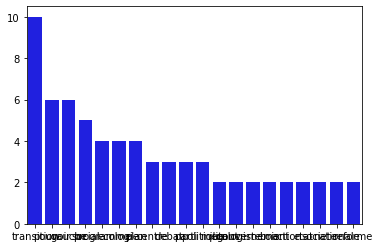

In [25]:
user_score = df_test.loc["lexicon_score_per_user"]
user_top_words = df_test["Anne_Hidalgo"].sort_values(ascending=False)[1:]

for word, recurrence_results in user_top_words.items():
    if recurrence_results == 0:
        user_top_words = user_top_words.drop(labels=word)
        
top_20_user_top_words = user_top_words[:20]

plot_index = list(top_20_user_top_words.index)
plot_values = list(top_20_user_top_words.values)
sns.barplot(x=plot_index, y=plot_values, color="b")

In [56]:
# plt.pie(plot_values, labels=plot_index)

### Check the words we let behind

In [ ]:
m=